In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:

from tqdm import tqdm_notebook

from itertools import product

# определяем среднюю среднюю процентную ошибку (MAPE) , так как это будет наша метрика ошибки

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
data = pd.read_csv("yahoo_stock.csv")
data.head(2000)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117


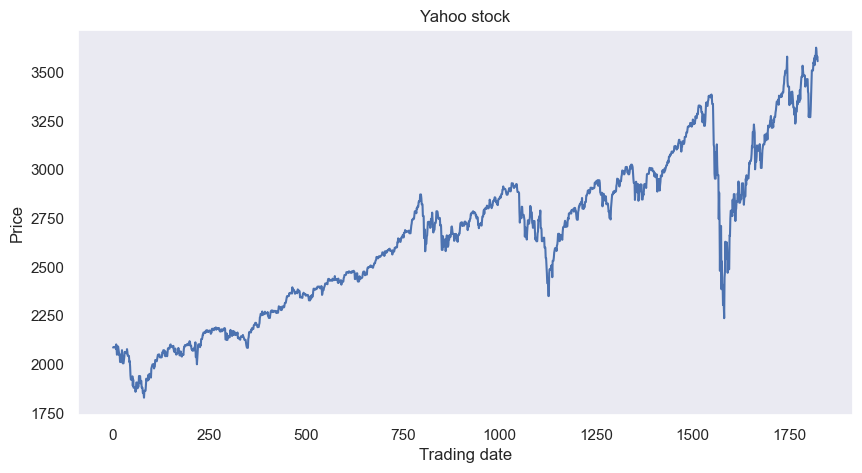

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(data.Close)
plt.title('Yahoo stock')
plt.ylabel('Price')
plt.xlabel('Trading date')
plt.grid(False)

plt.show()

In [5]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    

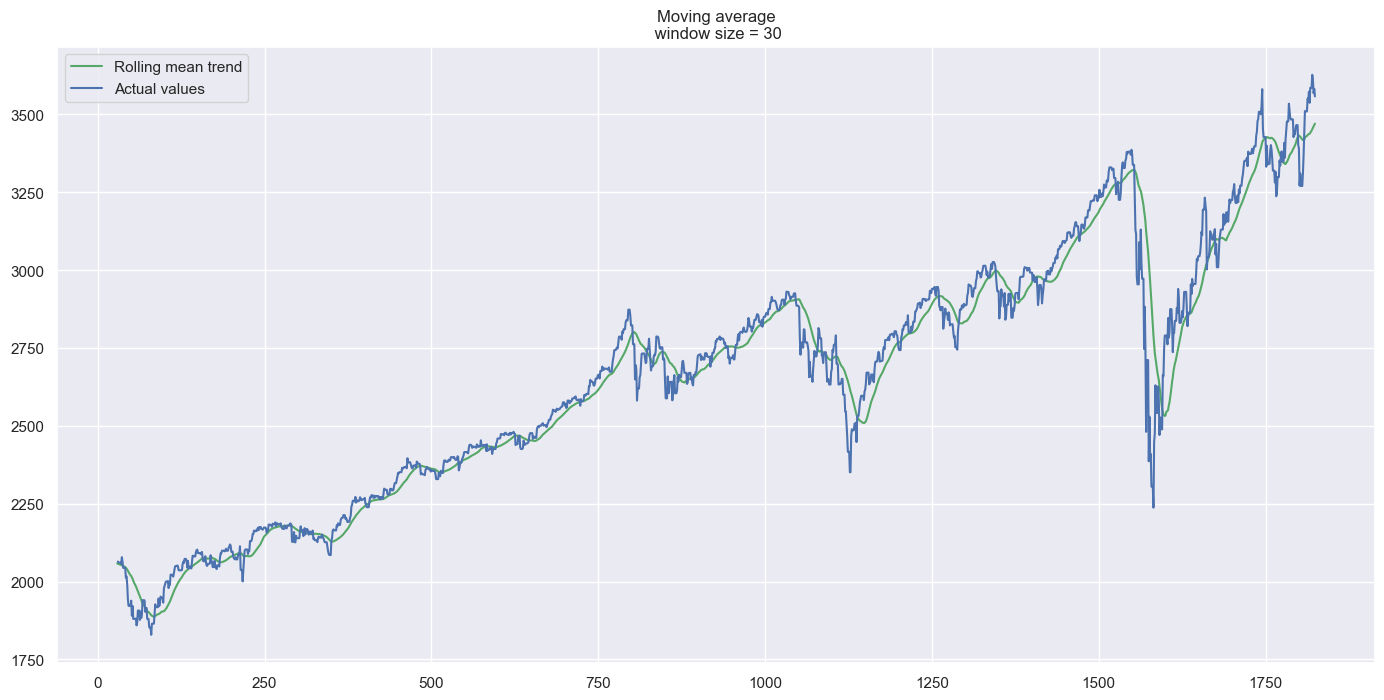

In [6]:
plot_moving_average(data.Close, 30)

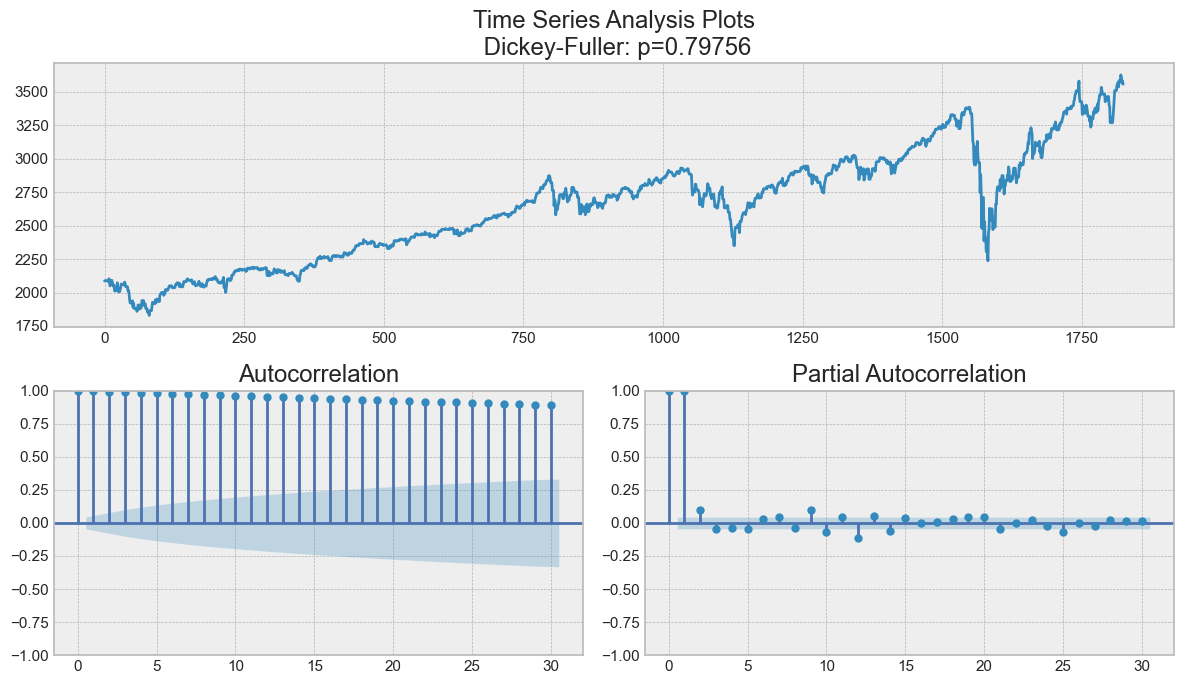

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)


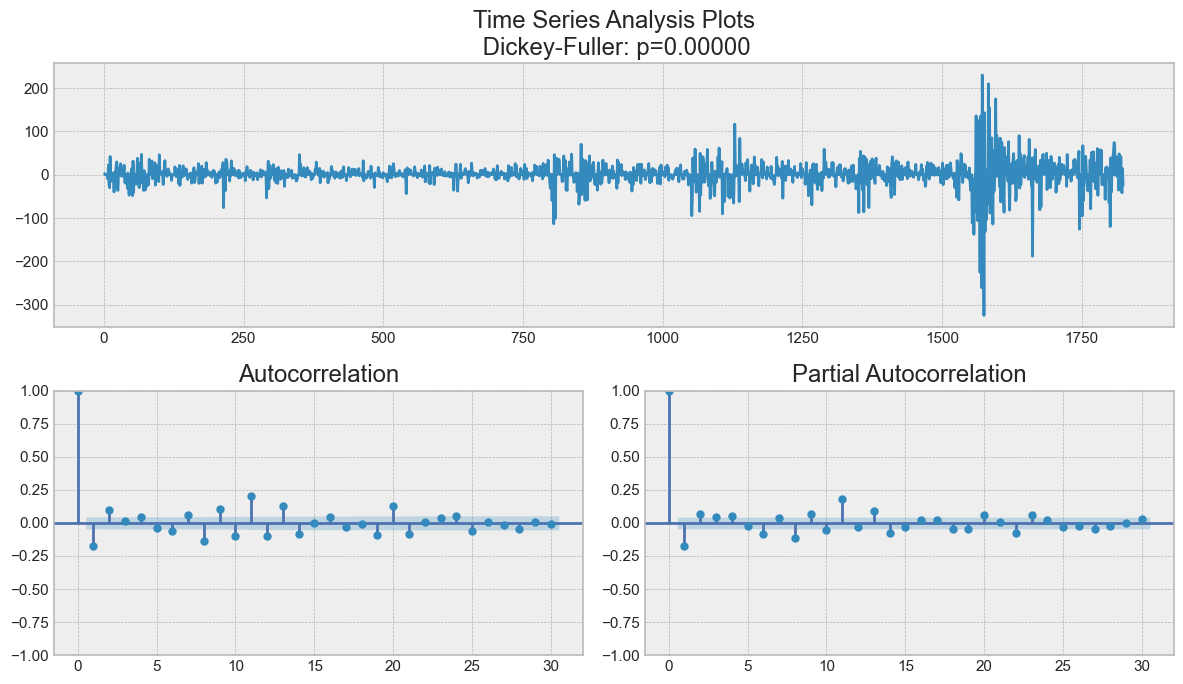

In [8]:

data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [9]:
# Установите начальные значения и некоторые границыs
ps = range(3)
d=1
qs = range(3)
Ps = range(2)
D=1
Qs = range(2)

# Составьте список со всеми возможными комбинациями параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['Close'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=True)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: total: 1min 37s
Wall time: 1min 43s


In [11]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 1825
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -8564.117
Date:                              Tue, 29 Nov 2022   AIC                          17140.233
Time:                                      08:44:03   BIC                          17173.246
Sample:                                           0   HQIC                         17152.416
                                             - 1825                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3449      0.085      4.045      0.000       0.178       0.512
ma.L1         -0.50

In [12]:
print(best_model.predict(start=data.Close.shape[0], end=data.Close.shape[0] + 5))

1825    3557.017636
1826    3555.730716
1827    3551.204611
1828    3554.255503
1829    3554.026950
1830    3553.991776
Name: predicted_mean, dtype: float64


In [13]:
comparison = pd.DataFrame({'actual': [3569.89454, 3593.10995, 3593.5445, 3628.51000, 3623.1101, 3585.21997],
                          'predicted': [ 3557.017636, 3555.730716, 3551.204610, 3554.255503, 3554.026949, 3553.991775]}, 
                          index = pd.date_range(start='2020-11-20', periods=6,))
comparison.head()

,actual,predicted
2020-11-20,3569.89454,3557.017636
2020-11-21,3593.10995,3555.730716
2020-11-22,3593.54450,3551.204610
2020-11-23,3628.51000,3554.255503
2020-11-24,3623.11010,3554.026949
